# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

plt.rcParams["figure.figsize"] = (15, 10)

In [2]:
df = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=df,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=37)

Found 7591 validated image filenames.


In [3]:
display(df.head())
df.info()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
real_age,7591.0,31.201159,17.14506,1.0,20.0,29.0,41.0,100.0


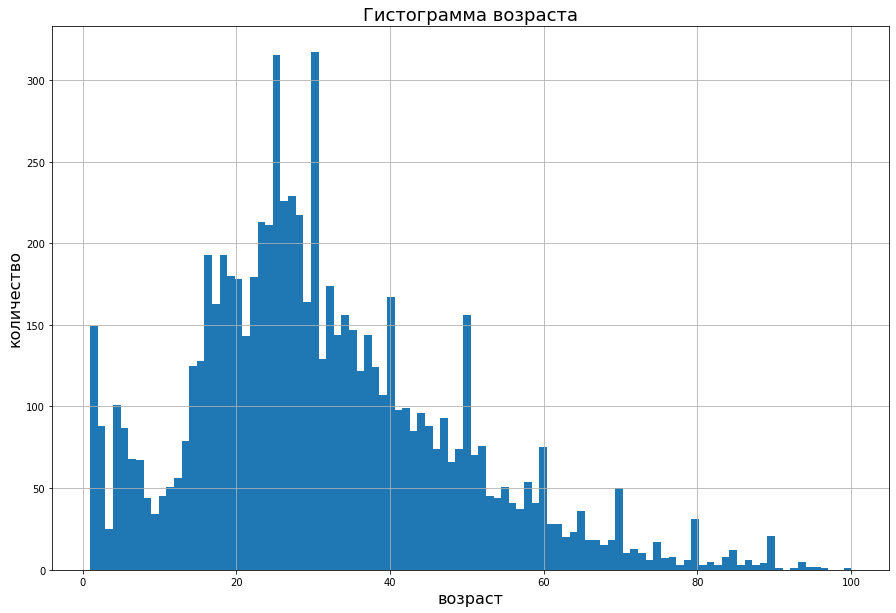

In [5]:
hist = df.real_age.hist(bins=100) 
  
plt.title('Гистограмма возраста', fontsize=18) 
plt.xlabel('возраст', fontsize=16) 
plt.ylabel('количество', fontsize=16) 
   
plt.show() 

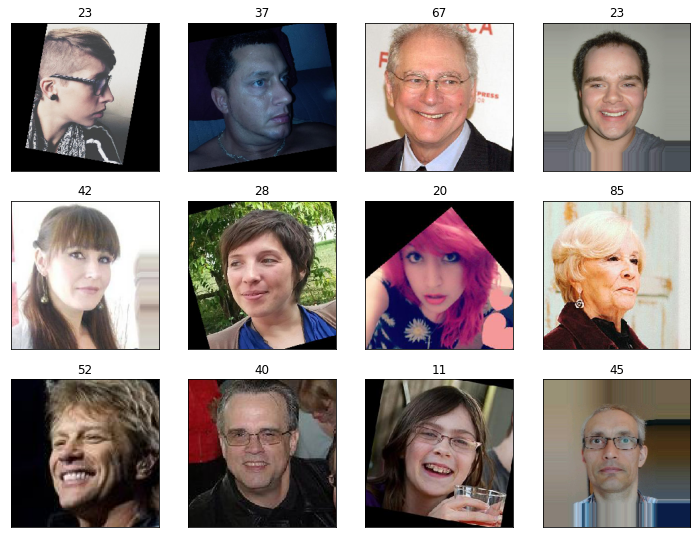

In [6]:
features, target = next(gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(12):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Выводы:

- В датафрейме содержатся фотографии людей разного возраста и пола в количестве 7591
- Оснавная часть возарста людей находится в диапазоне от 21 до 41 года,есть как годовалые дети,так и пожилые в возрасте 100 лет
- Изображения идут в формате jpg, имеют три цветовых канала RGB, квадратную форму и разные размеры 
- Лица на фотографиях расположены вертикально и занимают большую часть изображения, дополнительная обработка не потребуется
- Для предсказания буду использовать сверточную нейросеть ResNet

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import tensorflow as tf


def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
 
def create_model(input_shape):
 
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
 
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
 
 
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=8,
                steps_per_epoch=None, validation_steps=None):
 
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
 
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model
```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
Train for 356 steps, validate for 119 steps
Epoch 1/10
356/356 - 61s - loss: 231.1605 - mae: 11.0779 - val_loss: 645.1935 - val_mae: 20.4203
Epoch 2/10
356/356 - 49s - loss: 85.2219 - mae: 7.0340 - val_loss: 117.9912 - val_mae: 8.2575
Epoch 3/10
356/356 - 48s - loss: 58.2811 - mae: 5.8294 - val_loss: 88.7562 - val_mae: 7.2659
Epoch 4/10
356/356 - 48s - loss: 43.5569 - mae: 5.0490 - val_loss: 114.4741 - val_mae: 8.2163
Epoch 5/10
356/356 - 48s - loss: 30.4235 - mae: 4.2390 - val_loss: 76.8655 - val_mae: 6.7892
Epoch 6/10
356/356 - 49s - loss: 23.4294 - mae: 3.6821 - val_loss: 70.8930 - val_mae: 6.2423
Epoch 7/10
356/356 - 49s - loss: 18.5958 - mae: 3.2783 - val_loss: 65.7978 - val_mae: 6.2237
Epoch 8/10
356/356 - 46s - loss: 16.8992 - mae: 3.1462 - val_loss: 74.7817 - val_mae: 6.5172
Epoch 9/10
356/356 - 49s - loss: 15.3073 - mae: 2.9801 - val_loss: 71.4310 - val_mae: 6.3798
Epoch 10/10
356/356 - 48s - loss: 13.6169 - mae: 2.8028 - val_loss: 62.2602 - val_mae: 5.8204
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 12s - loss: 62.2602 - mae: 5.8204

```

## Анализ обученной модели

Построил модель сверточной нейронной сети на ResNet50 предобученной на наборе изображений ImageNet.

В процессе подбора оптимальных параметров я перебирал:

- learning_rate оптимизатора Adam
- количество эпох
- наличие и отсутствие аугментаций
- фиксацию основных весов нейронной сети и полное дообучение


За 8 эпох обучения на тестовой выборке удалось уменьшить MAE с 20 до 5.8, что соостветсвует заданию

Обученная модель с высокой точностью предсказывает возраст покупателей. Получение значения МАЕ 5.8 хороший результат, погрешность не большая

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы